In [7]:
#Importing the required libraries

import numpy as np
import os
import pandas as pd
import re
import cv2
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm
from glob import glob
import string

In [8]:
# A function to show images 

def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.clf()

### Matching poems

In [9]:
# function to clean text

def clean_text(text):
    text = text.lower()  #convert all characters to lowercase
    text = re.sub(r'\d+', '', text) #remove all numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation
    text = re.sub(r'\W', ' ', text) #remove special characters
    text = BeautifulSoup(text, "html.parser").get_text() #remove HTML tags
    return text

Example of ``` position_table ```:

``` 
{
  'roses': [0],
  'are': [1, 3],
  'red': [2],
  'violets': [4],
  'blue': [5]
} 
```

Example of ``` freq_table ```:

```
poem_db = {
  poem_0: (
    {'roses': 1, 'are': 2, 'red': 1, 'violets': 1, 'blue': 1},  # freq_table
    {
      'roses': [0],
      'are': [1, 3],
      'red': [2],
      'violets': [4],
      'blue': [5]
    }  # position_table
  )
}
```

In [10]:
#creating the lookup table to organise poem data

def create_lookup_table(text_data):
    poem_data = {}
    
    for poem_id, text in enumerate(text_data):
        freq_dict = {}
        position_dict = {}
        text = text.split()

        for idx, word in enumerate(text):
            if word in freq_dict:
                freq_dict[word] += 1
                position_dict[word].append(idx)
            else:
                freq_dict[word] = 1
                position_dict[word] = [idx]

        poem_data[f'poem_{poem_id}'] = [freq_dict, position_dict]

    return poem_data


In [11]:
#reconstruct poem from given poem lookup table and match_id

def reconstruct_poem(poem_db, match_id):
    matched_poem = poem_db[match_id]
    freq_table, position_table = matched_poem
    max_idx = 0

    for idx_lst in position_table.values():
        max_idx = max(np.max(idx_lst), max_idx)

    poem_text = ['']*(max_idx + 1)  # max_idx +1 to account for index starting from 0

    for key, value in position_table.items():
        for word_idx in value:
            poem_text[word_idx] = key

    return ' '.join(poem_text)

In [12]:
def search_poem(poem_db, poem_text):

    cleaned_search_text = clean_text(poem_text)
    search_words = cleaned_search_text.split()

    #create frequency vector (frequency of occurrence of each word) for search text
    search_freq = {}
    for word in search_words:
        search_freq[word] = search_freq.get(word, 0) + 1      #If word is already in search_freq, it returns the existing count.
                                                              #If not, it returns 0 as the default.
    
    max_similarity = -1
    matched_poem_idx = "poem_0"

    #compare each poem in database
    for poem_id, poem_data in poem_db.items():
        poem_freq = poem_data[0]   #extract frequency dictionary of current poem

        #way of comparison - cosine similarity
        all_words = set(search_freq.keys()).union(set(poem_freq.keys()))

        #create vectors
        v1 = np.array([search_freq.get(word, 0) for word in all_words])   #creates a vector with freq. of the word at each index corresponding
        v2 = np.array([poem_freq.get(word, 0) for word in all_words])   #to all_words

        #calculate cosine similarity
        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)

        if norm_v1 == 0 or norm_v2 == 0:
            similarity = 0

        else:
            similarity = dot_product / (norm_v1 * norm_v2)

        #update best match
        if similarity > max_similarity:
            max_similarity = similarity
            matched_poem_idx = poem_id

    return matched_poem_idx


Reading the CSV file

In [13]:
text_data = pd.read_csv('preprocessed_data.csv', header=0)['text']
text_data = text_data.to_numpy()
print(f"Total poems: {text_data.shape[0]}")

text_data = np.array([clean_text(text) for text in text_data])

Total poems: 70


In [14]:
#create the poem_db dictionary with word_freq and word_idx
poem_db = create_lookup_table(text_data)

In [15]:
search_lst = [
                'i am a business man i am a methodical man method is the thing after all but there are no people',
                'as it is well known that the  wise men  came  from the east  and as mr touchandgo bullethead came from the east it follows that mr bullethead',
                'as mere mathematician he could not have reasoned at all and thus would have been at the mercy of the prefect',
                'i had no desire to oppose what i regarded as at best but a harmless and by no means an unnatural precaution     at the request of usher i personally aided him in the arrangements for the temporary entombment the body having'
             ]

In [16]:
for search_item in search_lst:
    matched_poem_idx = search_poem(poem_db, search_item)
    search_result = reconstruct_poem(poem_db, matched_poem_idx)

    print('='*10)
    print(f'For search text: {search_item}')
    print('Found poem: ')
    print(search_result)
    print('='*10)
    

For search text: i am a business man i am a methodical man method is the thing after all but there are no people
Found poem: 
true nervous very very dreadfully nervous i had been and am but why will you say that i am mad the disease had sharpened my senses not destroyed not dulled them above all was the sense of hearing acute i heard all things in the heaven and in the earth i heard many things in hell how then am i mad hearken and observe how healthily how calmly i can tell you the whole story it is impossible to say how first the idea entered my brain but once conceived it haunted me day and night object there was none passion there was none i loved the old man he had never wronged me he had never given me insult for his gold i had no desire i think it was his eye yes it was this he had the eye of a vulture a pale blue eye with a film over it whenever it fell upon me my blood ran cold and so by degrees very gradually i made up my mind to take the life of the old man and thus rid myse

### Searching photos


In [17]:
#Loading all images
mean_images = []
mean_img_classes = []
search_images = []
search_img_classes = []

for files in tqdm(natsorted(glob(r'images\mean_images\*'))):
    mean_images.append(cv2.imread(files, 1))
    mean_img_classes.append(os.path.splitext(os.path.basename(files))[0])

for files in tqdm(natsorted(glob(r'images\search_images\*'))):
    search_images.append(cv2.imread(files, 1))
    search_img_classes.append(os.path.splitext(os.path.basename(files))[0].split('_')[0])

mean_images = np.array(mean_images) # Only possible because all images are of same size
search_images = np.array(search_images)

100%|██████████| 110/110 [00:00<00:00, 1448.73it/s]


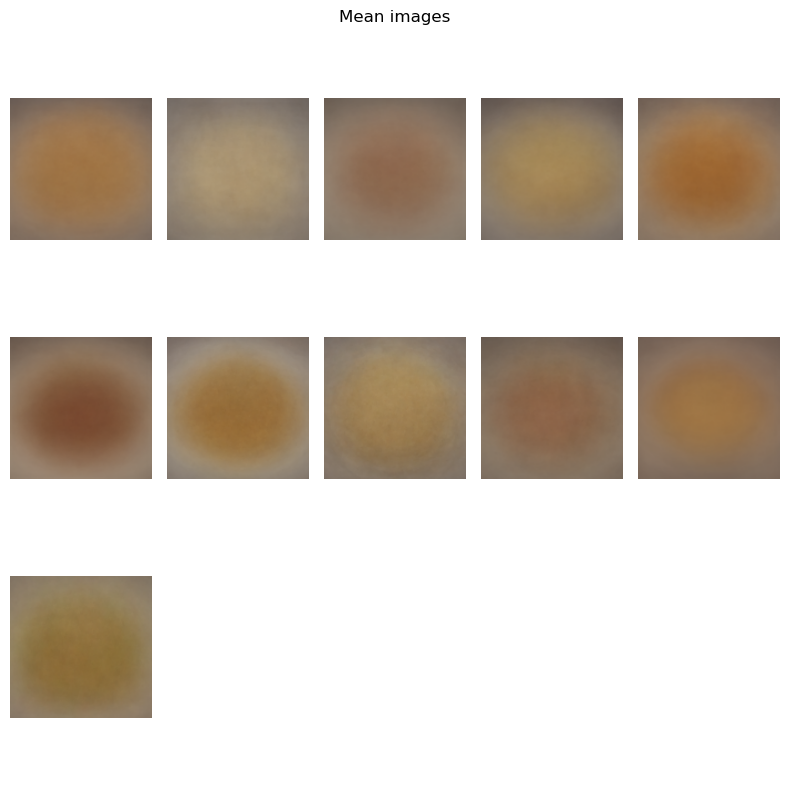

<Figure size 640x480 with 0 Axes>

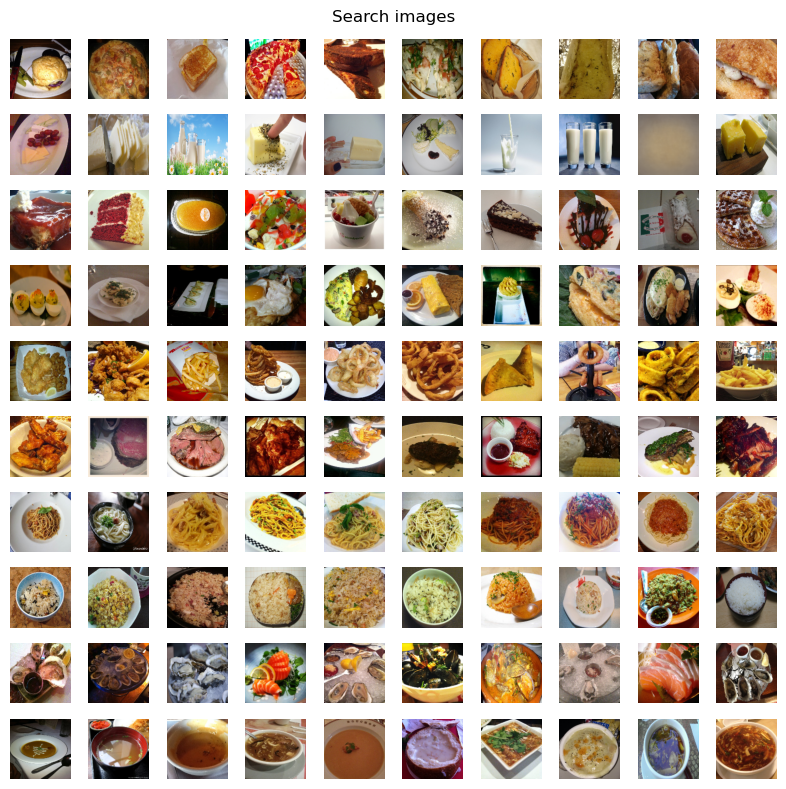

<Figure size 640x480 with 0 Axes>

In [18]:
show_image_grid(mean_images, 3, 5, "Mean images", figsize=8)
show_image_grid(search_images, 10, 10, "Search images", figsize=8)

In [ ]:
def image_lookup_fn(mean_images, query_image, mean_img_classes):
    best_match_idx = 0
    # min_distance = float("inf")
    max_similarity = 0

    #convert query image to grayscale (single channel) and flatten (to make a vector)
    query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
    query_flat = query_gray.flatten().astype(np.float32)

    #normalize query image vector
    query_norm = query_flat / np.linalg.norm(query_flat)

    for idx, mean_image in enumerate(mean_images):

        #same grayscale and flatten operations for mean image
        mean_gray = cv2.cvtColor(mean_image, cv2.COLOR_BGR2GRAY)
        mean_flat = mean_gray.flatten().astype(np.float32)

        #normalize mean image vector
        mean_norm = mean_flat / np.linalg.norm(mean_flat)
        
        #find cosine similarity
        cos_sim = np.dot(query_norm, mean_norm)  

        if cos_sim > max_similarity:
            max_similarity = cos_sim
            best_match_idx = idx

    return mean_img_classes[best_match_idx]

100%|██████████| 110/110 [00:00<00:00, 556.57it/s]


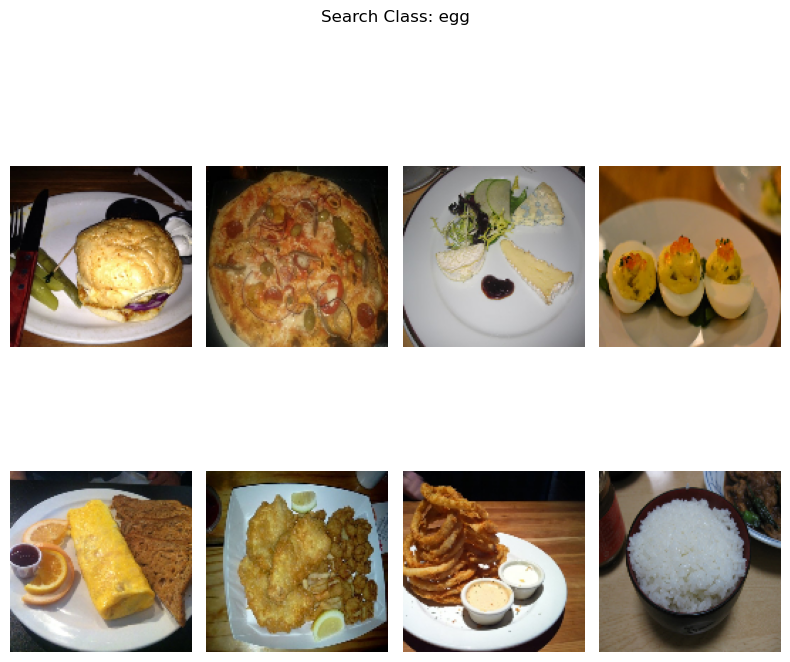

<Figure size 640x480 with 0 Axes>

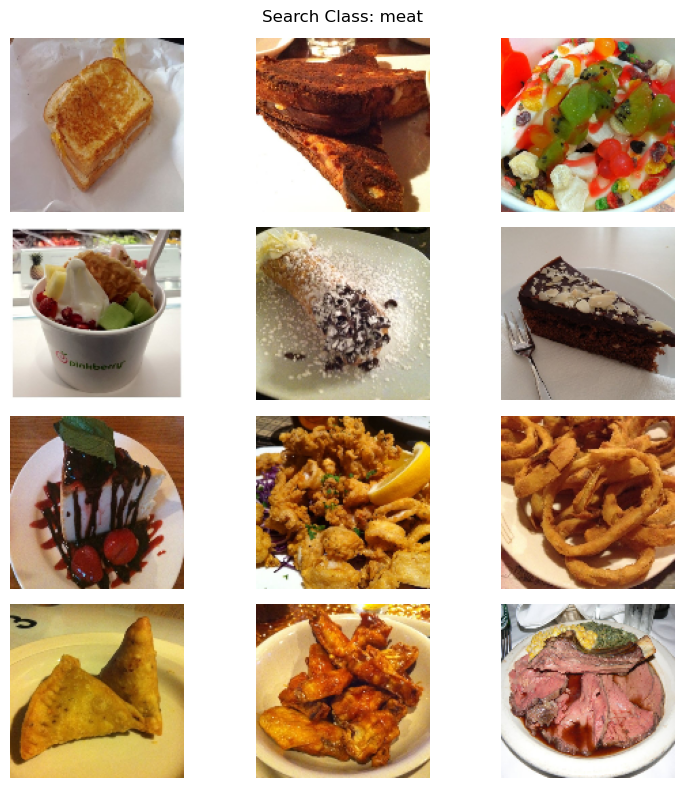

<Figure size 640x480 with 0 Axes>

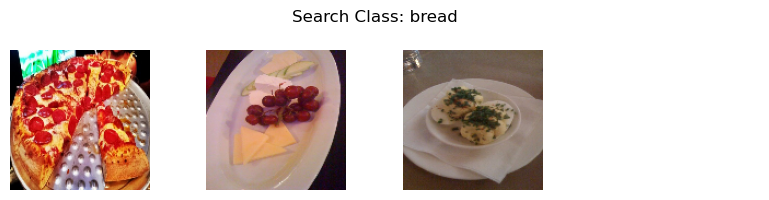

<Figure size 640x480 with 0 Axes>

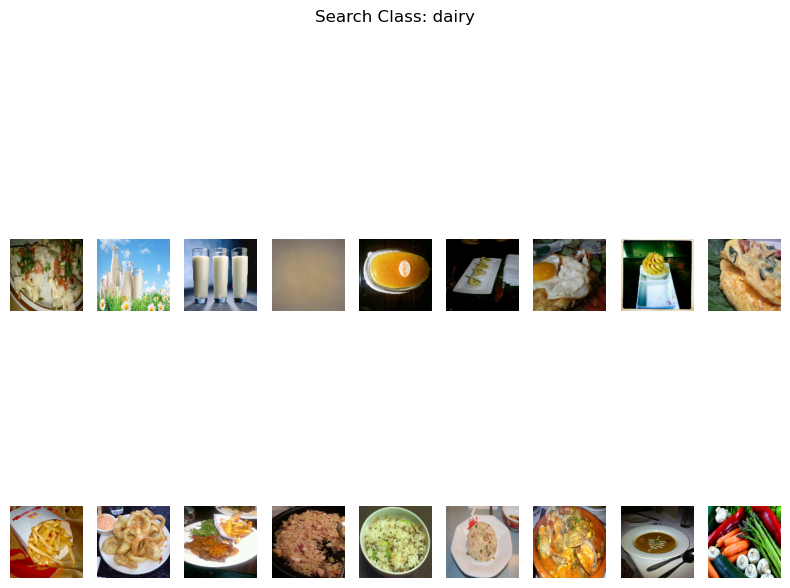

<Figure size 640x480 with 0 Axes>

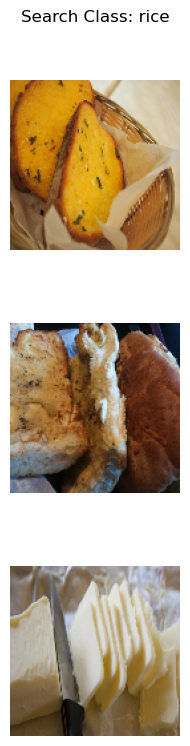

<Figure size 640x480 with 0 Axes>

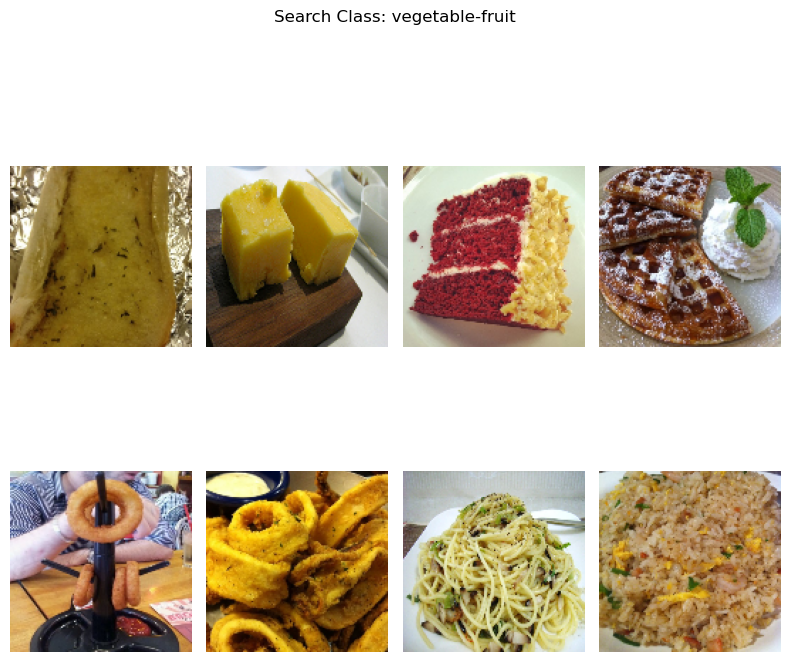

<Figure size 640x480 with 0 Axes>

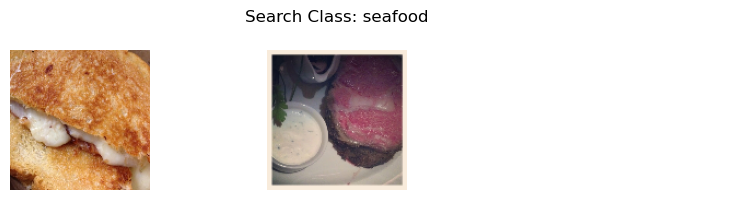

<Figure size 640x480 with 0 Axes>

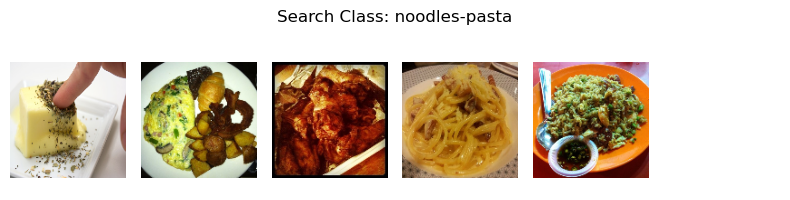

<Figure size 640x480 with 0 Axes>

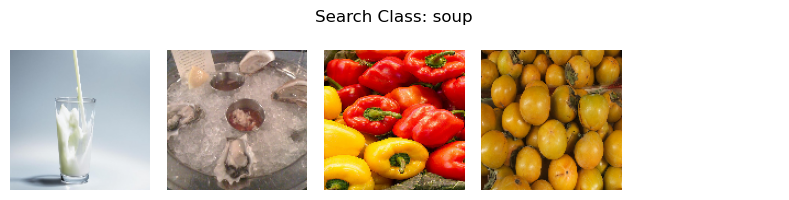

<Figure size 640x480 with 0 Axes>

In [24]:
pred_classes = []
cluster_images = {}

for query_image in tqdm(search_images):
    pred_classes.append(image_lookup_fn(mean_images, query_image, mean_img_classes))
    if pred_classes[-1] in cluster_images:
        cluster_images[pred_classes[-1]].append(query_image)
    else:
        cluster_images[pred_classes[-1]] = [query_image]

for class_name, img_lst in cluster_images.items():
    img_lst = np.array(img_lst)
    M = img_lst.shape[0]//10 + 1
    N = img_lst.shape[0]%10 + 1
    show_image_grid(img_lst, M, N, f'Search Class: {class_name}', figsize=8)

In [25]:
# Calculate the accruacy (pred_classes, search_img_classes)

def calculate_accuracy(pred_classes, true_classes):
    correct = sum(1 for p, t in zip(pred_classes, true_classes) if p == t)
    total = len(pred_classes)
    accuracy = (correct / total) * 100
    return accuracy

accuracy = calculate_accuracy(pred_classes, search_img_classes)
print(f"Classification Accuracy: {accuracy:.2f}%")


Classification Accuracy: 17.27%
